In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.optimize import linear_sum_assignment
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
# Load the training data
df_train = pd.read_csv('BattingOrder.csv')
df_train = df_train.drop(df_train.columns[[0, 1]], axis=1)

df_train = df_train.rename(columns={'Handedness': 'batsHand', 'Height (cm)': 'height_cm', 'Weight (lbs)': 'weight_lbs'})
df_train = df_train.round(decimals=4)
df_train['Offical_order'] = df_train['Offical_order'].astype(int)
df_train['Order_v_L'] = df_train['Order_v_L'].astype(int)
df_train['Order_v_R'] = df_train['Order_v_R'].astype(int)
df_train.head()

,Name,height_cm,weight_lbs,batsHand,SB,AB_L,AVG_L,OBP_L,SLG_L,wRC_L,wOBA_L,AB_R,AVG_R,OBP_R,SLG_R,wRC_R,wOBA_R,Offical_order,Order_v_L,Order_v_R
0,Miguel Cabrera,193,267,R,0,86,0.2674,0.3535,0.3372,11.5041,0.3116,248,0.2540,0.3100,0.3589,27.6279,0.2944,7,7,7
1,David Peralta,185,210,L,4,35,0.3143,0.3333,0.3429,3.8080,0.2990,359,0.2535,0.2902,0.3844,37.8072,0.2896,6,6,6
2,Carlos Santana,180,210,S,6,139,0.2662,0.3540,0.4532,23.7136,0.3490,411,0.2311,0.3057,0.4209,54.2470,0.3143,4,4,4
3,Nelson Cruz,188,230,R,1,83,0.2410,0.2809,0.3855,8.2368,0.2831,60,0.2500,0.2857,0.4167,6.8043,0.3017,5,5,5
4,Tommy Pham,185,223,R,22,155,0.2452,0.3220,0.4645,23.8056,0.3334,271,0.2620,0.3322,0.4354,40.3177,0.3314,3,3,3


In [ ]:
# Not Hand Specific
# Define numerical and categorical features based on the actual column names in your CSV
numerical_features = ['AVG_R', 'OBP_R', 'SLG_R', 'wOBA_R', 'SB', 'wRC_R', 'AVG_L', 'OBP_L', 'SLG_L', 'wOBA_L', 'height_cm', 'weight_lbs', 'wRC_L']#, 'weight_lbs'
categorical_features = ['batsHand']  # Adjust if you have different categorical features
feature_columns = ['AVG_R', 'OBP_R', 'SLG_R', 'wOBA_R', 'SB', 'wRC_R', 'AVG_L', 'OBP_L', 'SLG_L', 'wOBA_L', 'wRC_L', 'height_cm', 'weight_lbs', 'batsHand']
target_column = 'Offical_order'

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a classifier
classifier = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=9
)

# Create a full pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_train[feature_columns],
    df_train[target_column],
    test_size=0.2,
    stratify=df_train[target_column],
    random_state=42
)
y_train = y_train - 1
y_test = y_test - 1

# Train the model
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)
y_pred = y_pred
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.17      0.20      0.18        10
           1       0.38      0.33      0.35         9
           2       0.25      0.25      0.25         8
           3       0.00      0.00      0.00        10
           4       0.50      0.22      0.31         9
           5       0.00      0.00      0.00        10
           6       0.10      0.10      0.10        10
           7       0.32      0.46      0.37        13
           8       0.50      0.57      0.53        14

    accuracy                           0.26        93
   macro avg       0.25      0.24      0.23        93
weighted avg       0.25      0.26      0.25        93

[[2 1 0 1 0 1 3 1 1]
 [0 3 2 2 0 1 0 1 0]
 [2 1 2 1 0 1 1 0 0]
 [1 2 3 0 1 1 1 1 0]
 [1 1 0 1 2 1 1 1 1]
 [3 0 1 0 0 0 1 4 1]
 [3 0 0 2 0 0 1 3 1]
 [0 0 0 1 0 1 1 6 4]
 [0 0 0 1 1 1 1 2 8]]


In [ ]:
y_pred_prob = model.predict_proba(X_test)

# Calculate the Binary Cross-Entropy Loss between the true labels and predicted probabilities
bce_loss = log_loss(y_test, y_pred_prob)

# Print out the BCE Loss for evaluation
print("BCE Loss:", bce_loss)

BCE Loss: 2.3036746753424637


In [ ]:
# To use the model for predicting the batting order of new players
new_players_data = pd.read_csv('TamuPlayerStats.csv')
new_players_data = new_players_data.rename(columns={'height': 'height_cm', 'weight': 'weight_lbs'})
# convert inches to centimeters
new_players_data['height_cm'] = new_players_data['height_cm'] * 2.54
new_players_data = new_players_data.round(decimals=4)
new_players_data = new_players_data.sort_values(by='AB_R', ascending=False)
# Selecting the top 16 rows
new_players_data = new_players_data.head(16)

# Preprocess the new player data
new_players_preprocessed = model.named_steps['preprocessor'].transform(new_players_data[feature_columns])

# Predict probabilities for each batting order position for all new players
probabilities = model.named_steps['classifier'].predict_proba(new_players_preprocessed)

# Calculate suitability scores
suitability_scores = probabilities.sum(axis=1)

# Select the top 9 players based on suitability scores
top_player_indices = np.argsort(-suitability_scores)[:9]
selected_players = new_players_data.iloc[top_player_indices]

# Re apply preprocessing
selected_players_preprocessed = model.named_steps['preprocessor'].transform(selected_players[feature_columns])

# Re-calculate probabilities for just the top 9 selected players
selected_probabilities = model.named_steps['classifier'].predict_proba(selected_players_preprocessed)

# Convert probabilities to cost for the Hungarian algorithm
cost_matrix = 1 - selected_probabilities

# Optimize batting order assignment
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Construct DataFrame to display assigned positions with player names
assigned_df = pd.DataFrame({
    'PlayerName': selected_players['playerFullName'].values,
    'AssignedPosition': col_ind + 1
}).sort_values('AssignedPosition')

# Reset index
assigned_df.reset_index(drop=True, inplace=True)

# Display
print(assigned_df)

        PlayerName  AssignedPosition
0       Max Kaufer                 1
1  Jace Laviolette                 2
2        Hank Bard                 3
3   Blake Binderup                 4
4   Gavin Grahovac                 5
5    Ali Camarillo                 6
6    Caden Sorrell                 7
7      Ryan Targac                 8
8  Travis Chestnut                 9


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

param_grid = {
    'classifier__learning_rate': [.001, 0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__n_estimators': [300, 400, 500, 550],
    'classifier__min_child_weight': [1, 3, 5],
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

In [ ]:
print("Best Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
best_log_loss = -random_search.best_score_
print("\nBest Log Loss (Cross-Validation):", best_log_loss)

Best Parameters Found:
  classifier__subsample: 0.7
  classifier__n_estimators: 300
  classifier__min_child_weight: 5
  classifier__max_depth: 4
  classifier__learning_rate: 0.01
  classifier__colsample_bytree: 0.8

Best Log Loss (Cross-Validation): 1.9597454889668469


In [ ]:
# Retrieve the best model from random search
best_model = random_search.best_estimator_

# Use the best model to make predictions on the test data
y_pred_prob = best_model.predict_proba(X_test)

# Calculate the Binary Cross-Entropy (BCE) Loss between the true labels and predicted probabilities
bce_loss = log_loss(y_test, y_pred_prob)

# Print out the BCE Loss for evaluation
print("BCE Loss:", bce_loss)


BCE Loss: 1.9330903633755618


In [ ]:
# Hard code params from the search
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

# Initialize the classifier with the best hyperparameters found
best_model = XGBClassifier(
    subsample=0.6,
    n_estimators=500,
    min_child_weight= 5,
    max_depth=4,
    learning_rate=0.01,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=9
)

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a full pipeline
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Fit the model on the entire training data
best_model.fit(X_train, y_train)

# Use the best model to make predictions on the test data
y_pred_prob = best_model.predict_proba(X_test)

# Calculate the Binary Cross-Entropy Loss between the true labels and predicted probabilities
bce_loss = log_loss(y_test, y_pred_prob)

# Print out the BCE Loss for evaluation
print("BCE Loss:", bce_loss)


BCE Loss: 1.9316141141091878


In [ ]:
# Predict on the test data
y_pred = best_model.predict(X_test)
y_pred = y_pred
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.50      0.40        10
           1       0.25      0.22      0.24         9
           2       0.33      0.38      0.35         8
           3       0.17      0.10      0.12        10
           4       0.38      0.33      0.35         9
           5       0.00      0.00      0.00        10
           6       0.17      0.10      0.12        10
           7       0.26      0.46      0.33        13
           8       0.46      0.43      0.44        14

    accuracy                           0.29        93
   macro avg       0.26      0.28      0.26        93
weighted avg       0.27      0.29      0.27        93

[[5 2 0 0 0 1 1 0 1]
 [0 2 3 2 0 1 0 1 0]
 [2 1 3 1 0 0 0 0 1]
 [1 2 1 1 2 0 0 3 0]
 [2 0 1 0 3 0 0 3 0]
 [2 1 1 0 0 0 1 4 1]
 [3 0 0 0 1 1 1 3 1]
 [0 0 0 1 1 1 1 6 3]
 [0 0 0 1 1 1 2 3 6]]


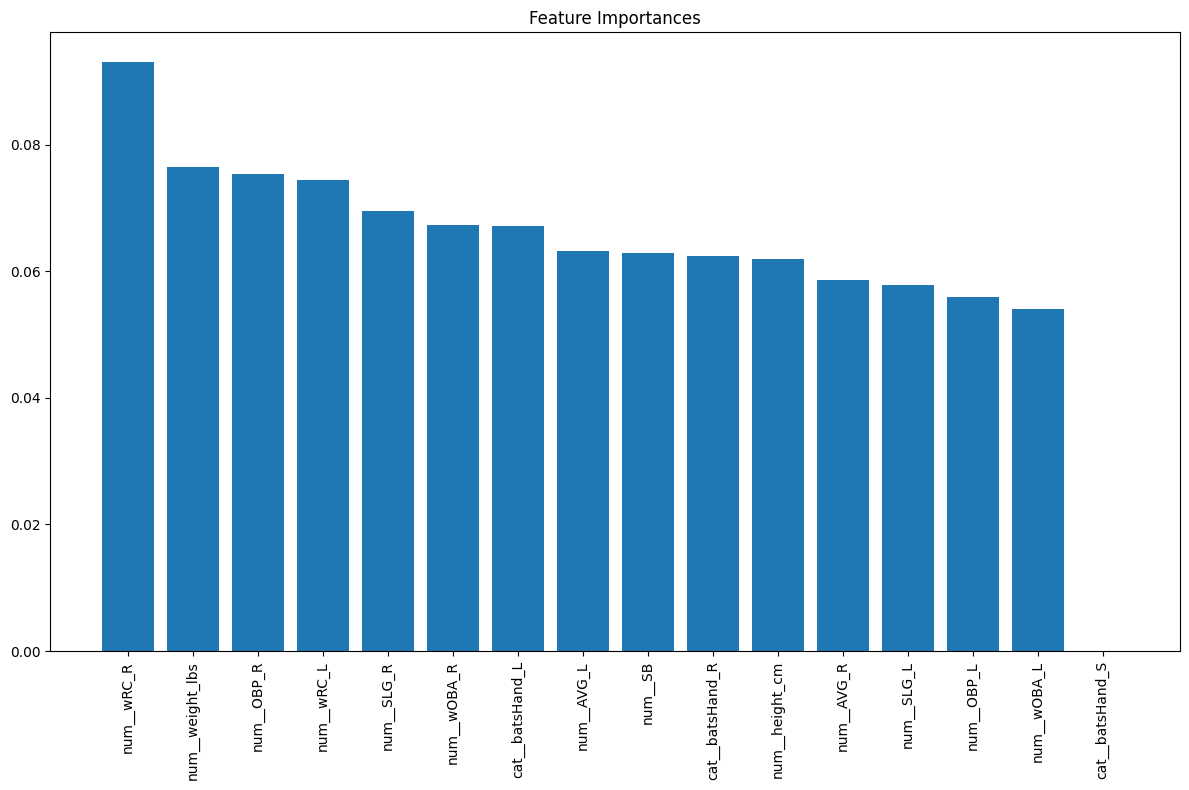

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from the model
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")

# Use the sorted indices to order feature names
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
# Testing with the new best data
new_players_data = pd.read_csv('TamuPlayerStats.csv')
new_players_data = new_players_data.rename(columns={'height': 'height_cm', 'weight': 'weight_lbs'})
# Convert inches to centimeters
new_players_data['height_cm'] = new_players_data['height_cm'] * 2.54
new_players_data = new_players_data.round(decimals=4)
new_players_data = new_players_data.sort_values(by='AB_R', ascending=False)
# Selecting the top 16 rows
new_players_data = new_players_data.head(16)

# Preprocess the new player data
new_players_preprocessed = best_model.named_steps['preprocessor'].transform(new_players_data[feature_columns])

# Predict probabilities for each batting order position for all new players
probabilities = best_model.named_steps['classifier'].predict_proba(new_players_preprocessed)

# Calculate suitability scores
suitability_scores = probabilities.sum(axis=1)

# Select the top 9 players based on suitability scores
top_player_indices = np.argsort(-suitability_scores)[:9]
selected_players = new_players_data.iloc[top_player_indices]

# Re-apply preprocessing
selected_players_preprocessed = best_model.named_steps['preprocessor'].transform(selected_players[feature_columns])

# Re-calculate probabilities
selected_probabilities = best_model.named_steps['classifier'].predict_proba(selected_players_preprocessed)

# Convert probabilities to cost for the Hungarian algorithm
cost_matrix = 1 - selected_probabilities

# Optimize batting order assignment
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Construct DataFrame to display assigned positions with player names
assigned_df = pd.DataFrame({
    'PlayerName': selected_players['playerFullName'].values,
    'AssignedPosition': col_ind + 1
}).sort_values('AssignedPosition')

# Reset index
assigned_df.reset_index(drop=True, inplace=True)

# Display
print(assigned_df)

          PlayerName  AssignedPosition
0         Ted Burton                 1
1    Jace Laviolette                 2
2  Braden Montgomery                 3
3      Hayden Schott                 4
4     Gavin Grahovac                 5
5      Ali Camarillo                 6
6      Jackson Appel                 7
7     Blake Binderup                 8
8    Travis Chestnut                 9


In [ ]:
# Alternative way of using Hungarian Algo where we use all combinations
from itertools import combinations
# Testing with the new best data
new_players_data = pd.read_csv('TamuPlayerStats.csv')
new_players_data = new_players_data.rename(columns={'height': 'height_cm', 'weight': 'weight_lbs'})

new_players_data['height_cm'] = new_players_data['height_cm'] * 2.54
new_players_data = new_players_data.round(decimals=4)
new_players_data = new_players_data.sort_values(by='AB_R', ascending=False)

new_players_data = new_players_data.head(16)

new_players_preprocessed = best_model.named_steps['preprocessor'].transform(new_players_data[feature_columns])


probabilities = best_model.named_steps['classifier'].predict_proba(new_players_preprocessed)

# Define a function to calculate the total cost given a subset of players
def calculate_total_cost(players_indices):
    subset_probabilities = probabilities[players_indices, :]
    cost_matrix = 1 - subset_probabilities
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    return total_cost, row_ind, col_ind

# Get all combinations of players indices
player_indices = range(len(new_players_data))
player_combinations = combinations(player_indices, 9)

# Try each combination to find the one with the lowest total cost
min_total_cost = float('inf')
best_combination = None
best_assignment = None

for combo in player_combinations:
    total_cost, row_ind, col_ind = calculate_total_cost(combo)
    if total_cost < min_total_cost:
        min_total_cost = total_cost
        best_combination = combo
        best_assignment = col_ind + 1



# Construct the DataFrame with the best combination and assignments
assigned_df = pd.DataFrame({
    'PlayerName': new_players_data.iloc[list(best_combination)]['playerFullName'],
    'AssignedPosition': best_assignment
}).sort_values('AssignedPosition')

assigned_df.reset_index(drop=True, inplace=True)
print(assigned_df)


          PlayerName  AssignedPosition
0         Ted Burton                 1
1    Jace Laviolette                 2
2  Braden Montgomery                 3
3     Blake Binderup                 4
4     Gavin Grahovac                 5
5      Ali Camarillo                 6
6      Caden Sorrell                 7
7          Hank Bard                 8
8    Travis Chestnut                 9


In [ ]:
# Against Lefty Pitchers
df_left = df_train[['Name','SB', 'AB_L', 'AVG_L', 'OBP_L', 'SLG_L', 'wOBA_L', 'wRC_L', 'Order_v_L', 'height_cm', 'weight_lbs', 'batsHand']]
numerical_features = ['SB', 'AVG_L', 'OBP_L', 'SLG_L', 'wOBA_L', 'wRC_L', 'weight_lbs', 'height_cm']
categorical_features = ['batsHand']
feature_columns_L = ['SB', 'AVG_L', 'OBP_L', 'SLG_L', 'wOBA_L', 'wRC_L', 'height_cm', 'weight_lbs', 'batsHand']
target_column = 'Order_v_L'

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a classifier
classifier = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=9
)

# Create a full pipeline
model_L = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_left[feature_columns_L],
    df_left[target_column],
    test_size=0.2,
    stratify=df_left[target_column],
    random_state=42
)

y_train = y_train - 1
y_test = y_test - 1
# Train the model
model_L.fit(X_train, y_train)

# Predict on the test data
y_pred = model_L.predict(X_test)
y_pred = y_pred
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.30      0.26        10
           1       0.33      0.11      0.17         9
           2       0.50      0.50      0.50         8
           3       0.40      0.20      0.27        10
           4       0.40      0.44      0.42         9
           5       0.09      0.10      0.10        10
           6       0.17      0.10      0.12        10
           7       0.31      0.38      0.34        13
           8       0.33      0.50      0.40        14

    accuracy                           0.30        93
   macro avg       0.31      0.29      0.29        93
weighted avg       0.30      0.30      0.29        93

[[3 0 0 0 0 3 0 1 3]
 [1 1 3 1 0 2 1 0 0]
 [1 1 4 0 1 0 1 0 0]
 [1 0 1 2 2 1 0 2 1]
 [3 0 0 0 4 1 0 1 0]
 [0 0 0 0 0 1 2 4 3]
 [1 0 0 2 0 0 1 3 3]
 [1 1 0 0 2 0 0 5 4]
 [2 0 0 0 1 3 1 0 7]]


In [ ]:
y_pred_prob = model_L.predict_proba(X_test)

# Calculate the Binary Cross-Entropy Loss between the true labels and predicted probabilities
bce_loss = log_loss(y_test, y_pred_prob)

# Print out the BCE Loss for evaluation
print("BCE Loss:", bce_loss)

BCE Loss: 2.253938772700237


In [ ]:
# Testing with TAMU team
new_players_data = pd.read_csv('TamuPlayerStats.csv')
new_players_data = new_players_data.rename(columns={'height': 'height_cm', 'weight': 'weight_lbs'})
# convert inches to centimeters
new_players_data['height_cm'] = new_players_data['height_cm'] * 2.54
new_players_data = new_players_data.round(decimals=4)
new_players_data = new_players_data.sort_values(by='AB_L', ascending=False)
new_players_data = new_players_data.head(15)

# Apply preprocessing to the data
new_players_preprocessed = model_L.named_steps['preprocessor'].transform(new_players_data[feature_columns_L])

# Predict probabilities
probabilities = model_L.named_steps['classifier'].predict_proba(new_players_preprocessed)

# Calculate suitability scores and select the top 9 players
suitability_scores = probabilities.sum(axis=1)
top_player_indices = np.argsort(-suitability_scores)[:9]
selected_players = new_players_data.iloc[top_player_indices]

# Predict probabilities for the top 9 selected players
selected_probabilities = probabilities[top_player_indices]

# Convert to cost matrix and apply Hungarian algorithm
cost_matrix = 1 - selected_probabilities
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Construct and display the DataFrame with assigned positions
assigned_df = pd.DataFrame({
    'PlayerName': selected_players['playerFullName'],
    'AssignedPosition': col_ind + 1
}).sort_values('AssignedPosition')

assigned_df.reset_index(drop=True, inplace=True)
print(assigned_df)

          PlayerName  AssignedPosition
0      Caden Sorrell                 1
1          Hank Bard                 2
2         Ted Burton                 3
3      Jackson Appel                 4
4     Gavin Grahovac                 5
5    Jace Laviolette                 6
6  Braden Montgomery                 7
7        Kaeden Kent                 8
8      Ali Camarillo                 9


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

param_grid = {
    'classifier__learning_rate': [0.005, 0.01, .02],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.7, 0.8, 0.9, 1],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__n_estimators': [300,350, 400],
    'classifier__min_child_weight': [1, 3, 5],
}
random_search = RandomizedSearchCV(
    model_L,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

best_log_loss = -random_search.best_score_
print("\nBest Log Loss (Cross-Validation):", best_log_loss)

Best Parameters Found:
  classifier__subsample: 0.7
  classifier__n_estimators: 400
  classifier__min_child_weight: 5
  classifier__max_depth: 5
  classifier__learning_rate: 0.005
  classifier__colsample_bytree: 1.0

Best Log Loss (Cross-Validation): 2.0297499145764006


In [ ]:
# Retrieve the best model from random search
best_model_L= random_search.best_estimator_

# Use the best model to make predictions on the test data
y_pred_prob = best_model_L.predict_proba(X_test)

# Calculate the Binary Cross-Entropy Loss between the true labels and predicted probabilities
bce_loss = log_loss(y_test, y_pred_prob)

# Print out the BCE Loss for evaluation
print("BCE Loss:", bce_loss)


BCE Loss: 1.9703473474937148


In [ ]:
# Hard code params from the search
# Initialize the classifier with the best hyperparameters found
best_model_L = XGBClassifier(
    subsample=0.7,
    n_estimators=550,
    min_child_weight= 5,
    max_depth=5,
    learning_rate=0.005,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=9
)

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a full pipeline
best_model_L = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model_L)
])

# Fit the model on the entire training data
best_model_L.fit(X_train, y_train)

# Use the best model to make predictions on the test data
y_pred_prob = best_model_L.predict_proba(X_test)

# Calculate the Binary Cross-Entropy Loss between the true labels and predicted probabilities
bce_loss = log_loss(y_test, y_pred_prob)

# Print out the BCE Loss for evaluation
print("BCE Loss:", bce_loss)

BCE Loss: 1.9499684145901452


In [ ]:
# Predict on the test data
y_pred = best_model_L.predict(X_test)
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.27      0.40      0.32        10
           1       0.50      0.33      0.40         9
           2       0.56      0.62      0.59         8
           3       0.33      0.20      0.25        10
           4       0.44      0.44      0.44         9
           5       0.33      0.10      0.15        10
           6       0.17      0.10      0.12        10
           7       0.29      0.46      0.35        13
           8       0.44      0.57      0.50        14

    accuracy                           0.37        93
   macro avg       0.37      0.36      0.35        93
weighted avg       0.36      0.37      0.35        93

[[4 0 0 0 1 0 0 2 3]
 [2 3 2 1 0 0 0 1 0]
 [1 1 5 0 0 0 1 0 0]
 [2 1 1 2 2 0 0 2 0]
 [2 0 1 0 4 0 0 2 0]
 [0 0 0 1 0 1 2 4 2]
 [2 1 0 1 0 0 1 3 2]
 [0 0 0 1 1 1 1 6 3]
 [2 0 0 0 1 1 1 1 8]]


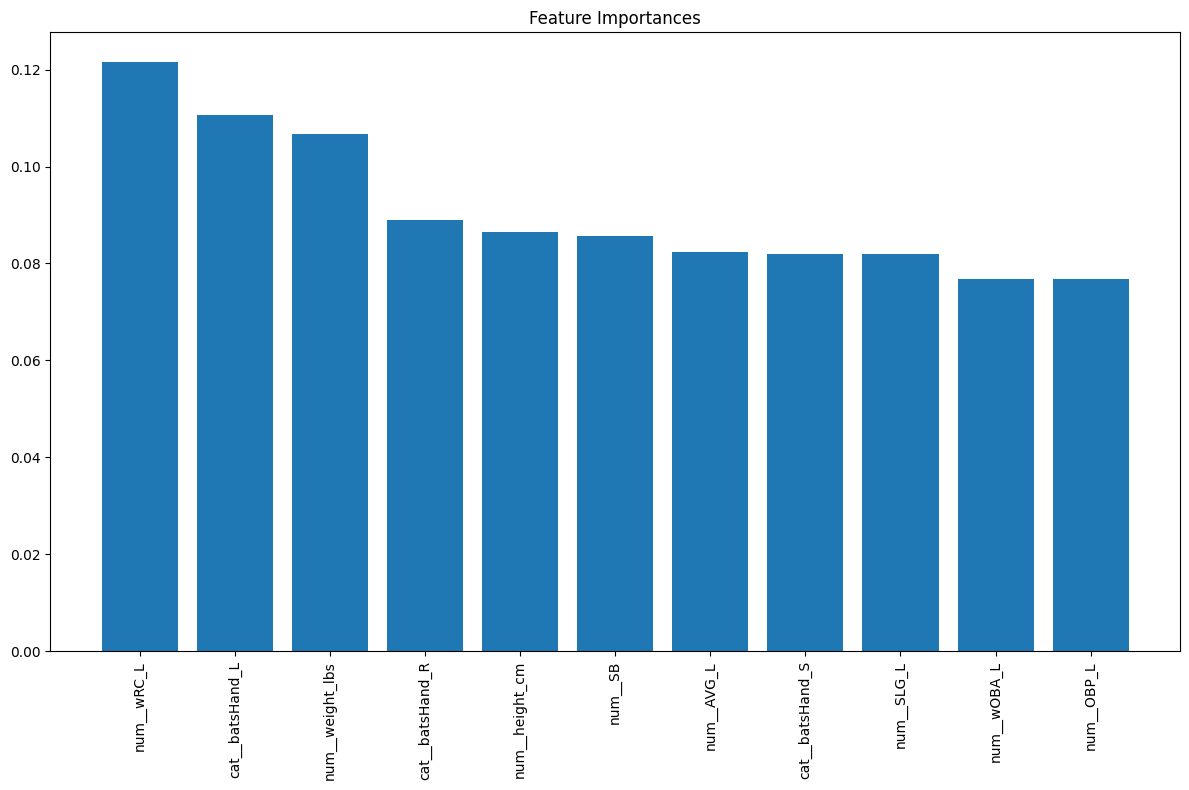

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature names from the preprocessor
feature_names = best_model_L.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from the model
feature_importances = best_model_L.named_steps['classifier'].feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")

# Use the sorted indices to order feature names
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
# Lefty model with new best params
new_players_data = pd.read_csv('TamuPlayerStats.csv')
new_players_data = new_players_data.rename(columns={'height': 'height_cm', 'weight': 'weight_lbs'})
new_players_data['height_cm'] = new_players_data['height_cm'] * 2.54
new_players_data = new_players_data.round(decimals=4)
new_players_data = new_players_data.sort_values(by='AB_L', ascending=False)
new_players_data = new_players_data.head(14)

new_players_preprocessed = best_model_L.named_steps['preprocessor'].transform(new_players_data[feature_columns_L])

# Predict probabilities
probabilities = best_model_L.named_steps['classifier'].predict_proba(new_players_preprocessed)

# Calculate suitability scores and select the top 9 players
suitability_scores = probabilities.sum(axis=1)
top_player_indices = np.argsort(-suitability_scores)[:9]
selected_players = new_players_data.iloc[top_player_indices]

# Predict probabilities for the top 9 selected players
selected_probabilities = probabilities[top_player_indices]

# Convert to cost matrix and apply Hungarian algorithm
cost_matrix = 1 - selected_probabilities
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Construct and display the DataFrame with assigned positions
assigned_df = pd.DataFrame({
    'PlayerName': selected_players['playerFullName'],
    'AssignedPosition': col_ind + 1
}).sort_values('AssignedPosition')

assigned_df.reset_index(drop=True, inplace=True)
print(assigned_df)

          PlayerName  AssignedPosition
0          Hank Bard                 1
1    Jace Laviolette                 2
2        Kaeden Kent                 3
3      Jackson Appel                 4
4     Gavin Grahovac                 5
5      Hayden Schott                 6
6  Braden Montgomery                 7
7         Ted Burton                 8
8      Ali Camarillo                 9


In [ ]:
# Alternative way of using Hungarian Algo where we use all combinations
from itertools import combinations
# Testing with the new best data
new_players_data = pd.read_csv('TamuPlayerStats.csv')
new_players_data = new_players_data.rename(columns={'height': 'height_cm', 'weight': 'weight_lbs'})

new_players_data['height_cm'] = new_players_data['height_cm'] * 2.54
new_players_data = new_players_data.round(decimals=4)
new_players_data = new_players_data.sort_values(by='AB_R', ascending=False)
# Selecting the top 13 rows
new_players_data = new_players_data.head(16)

# Preprocess the new player data
new_players_preprocessed = best_model.named_steps['preprocessor'].transform(new_players_data[feature_columns])

# Predict probabilities for each batting order position for all new players
probabilities = best_model.named_steps['classifier'].predict_proba(new_players_preprocessed)

# Define a function to calculate the total cost given a subset of players
def calculate_total_cost(players_indices):

    subset_probabilities = probabilities[players_indices, :]
    cost_matrix = 1 - subset_probabilities
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    return total_cost, row_ind, col_ind

# Get all combinations of players indices
player_indices = range(len(new_players_data))
player_combinations = combinations(player_indices, 9)

# Try each combination to find the one with the lowest total cost
min_total_cost = float('inf')
best_combination = None
best_assignment = None

for combo in player_combinations:
    total_cost, row_ind, col_ind = calculate_total_cost(combo)
    if total_cost < min_total_cost:
        min_total_cost = total_cost
        best_combination = combo
        best_assignment = col_ind + 1

# Construct the DataFrame with the best combination and assignments
assigned_df = pd.DataFrame({
    'PlayerName': new_players_data.iloc[list(best_combination)]['playerFullName'],
    'AssignedPosition': best_assignment
}).sort_values('AssignedPosition')

assigned_df.reset_index(drop=True, inplace=True)
print(assigned_df)


          PlayerName  AssignedPosition
0         Ted Burton                 1
1    Jace Laviolette                 2
2  Braden Montgomery                 3
3     Blake Binderup                 4
4     Gavin Grahovac                 5
5      Ali Camarillo                 6
6      Caden Sorrell                 7
7          Hank Bard                 8
8    Travis Chestnut                 9


In [ ]:
# Against Righty Pitchers
df_right = df_train[['Name','SB', 'AB_R', 'AVG_R', 'OBP_R', 'SLG_R', 'wOBA_R', 'wRC_R', 'Order_v_R', 'height_cm', 'weight_lbs', 'batsHand']]
numerical_features = ['SB', 'AVG_R', 'OBP_R', 'SLG_R', 'wOBA_R', 'wRC_R', 'height_cm', 'weight_lbs']
categorical_features = ['batsHand']
feature_columns_R = ['SB', 'AVG_R', 'OBP_R', 'SLG_R', 'wOBA_R', 'wRC_R', 'height_cm', 'weight_lbs', 'batsHand']
target_column = 'Order_v_R'

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a classifier
classifier = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=9
)

# Create a full pipeline
model_R = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_right[feature_columns_R],
    df_right[target_column],
    test_size=0.2,
    stratify=df_right[target_column],
    random_state=42
)

y_train = y_train - 1
y_test = y_test - 1

model_R.fit(X_train, y_train)

# Predict on the test data
y_pred = model_R.predict(X_test)
y_pred = y_pred
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.10      0.12        10
           1       0.27      0.33      0.30         9
           2       0.30      0.38      0.33         8
           3       0.00      0.00      0.00        10
           4       0.33      0.22      0.27         9
           5       0.21      0.30      0.25        10
           6       0.29      0.20      0.24        10
           7       0.25      0.23      0.24        13
           8       0.31      0.36      0.33        14

    accuracy                           0.24        93
   macro avg       0.23      0.24      0.23        93
weighted avg       0.24      0.24      0.23        93

[[1 3 0 3 0 0 0 1 2]
 [0 3 3 1 0 1 0 1 0]
 [3 0 3 0 0 1 0 0 1]
 [0 4 1 0 1 2 1 1 0]
 [0 0 1 1 2 1 1 2 1]
 [2 0 1 1 1 3 0 1 1]
 [1 0 0 2 1 2 2 0 2]
 [0 0 1 1 1 2 1 3 4]
 [0 1 0 1 0 2 2 3 5]]


In [ ]:
y_pred_prob = model_R.predict_proba(X_test)

# Calculate the Binary Cross-Entropy (BCE) Loss between the true labels and predicted probabilities
bce_loss = log_loss(y_test, y_pred_prob)

# Print out the BCE Loss for evaluation
print("BCE Loss:", bce_loss)

BCE Loss: 2.3724423274037454


In [ ]:
new_players_data = pd.read_csv('TamuPlayerStats.csv')
new_players_data = new_players_data.rename(columns={'height': 'height_cm', 'weight': 'weight_lbs'})
new_players_data['height_cm'] = new_players_data['height_cm'] * 2.54
new_players_data = new_players_data.round(decimals=4)
new_players_data = new_players_data.sort_values(by='AB_R', ascending=False)
new_players_data = new_players_data.head(16)

# Apply preprocessing to the data
new_players_preprocessed = model_R.named_steps['preprocessor'].transform(new_players_data[feature_columns_R])

# Predict probabilities
probabilities = model_R.named_steps['classifier'].predict_proba(new_players_preprocessed)

# Calculate suitability scores and select the top 9 players
suitability_scores = probabilities.sum(axis=1)
top_player_indices = np.argsort(-suitability_scores)[:9]
selected_players = new_players_data.iloc[top_player_indices]

# Predict probabilities for the top 9 selected players
selected_probabilities = probabilities[top_player_indices]

# Convert to cost matrix and apply Hungarian algorithm
cost_matrix = 1 - selected_probabilities
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Construct and display the DataFrame with assigned positions
assigned_df = pd.DataFrame({
    'PlayerName': selected_players['playerFullName'],
    'AssignedPosition': col_ind + 1
}).sort_values('AssignedPosition')

assigned_df.reset_index(drop=True, inplace=True)
print(assigned_df)

          PlayerName  AssignedPosition
0      Ali Camarillo                 1
1         Ted Burton                 2
2      Hayden Schott                 3
3  Braden Montgomery                 4
4     Gavin Grahovac                 5
5    Jace Laviolette                 6
6      Caden Sorrell                 7
7        Kaeden Kent                 8
8        Ryan Targac                 9


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

param_grid = {
    'classifier__learning_rate': [0.008, 0.005, 0.01, .015],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__subsample': [0.4, 0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'classifier__n_estimators': [550, 500, 400],
    'classifier__min_child_weight': [1, 3, 5, 7],
}

random_search = RandomizedSearchCV(
    model_R,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

best_log_loss = -random_search.best_score_
print("\nBest Log Loss (Cross-Validation):", best_log_loss)

Best Parameters Found:
  classifier__subsample: 0.4
  classifier__n_estimators: 500
  classifier__min_child_weight: 7
  classifier__max_depth: 5
  classifier__learning_rate: 0.01
  classifier__colsample_bytree: 0.8

Best Log Loss (Cross-Validation): 1.930899967727185


In [ ]:
# Retrieve the best model from random search
best_model_R = random_search.best_estimator_

# Use the best model to make predictions on the test data
y_pred_prob = best_model_R.predict_proba(X_test)

# Calculate the Binary Cross-Entropy Loss between the true labels and predicted probabilities
bce_loss = log_loss(y_test, y_pred_prob)

# Print out the BCE Loss for evaluation
print("BCE Loss:", bce_loss)


BCE Loss: 1.9479000302902536


In [ ]:
# Hard code params
# Initialize the classifier with the best hyperparameters found
best_model_R = XGBClassifier(
    subsample= 0.4,
    n_estimators= 500,
    min_child_weight= 7,
    max_depth= 5,
    learning_rate= 0.01,
    colsample_bytree = 1.0,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=9
)

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a full pipeline
best_model_R = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model_R)
])

# Fit the model on the entire training data
best_model_R.fit(X_train, y_train)

# Use the best model to make predictions on the test data
y_pred_prob = best_model_R.predict_proba(X_test)

# Calculate the Binary Cross-Entropy Loss between the true labels and predicted probabilities
bce_loss = log_loss(y_test, y_pred_prob)

# Print out the BCE Loss for evaluation
print("BCE Loss:", bce_loss)

BCE Loss: 1.9396690750065442


In [ ]:
# Predict on the test data
y_pred = best_model_R.predict(X_test)
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.27      0.40      0.32        10
           1       0.50      0.44      0.47         9
           2       0.14      0.12      0.13         8
           3       0.67      0.20      0.31        10
           4       0.25      0.33      0.29         9
           5       0.38      0.30      0.33        10
           6       0.00      0.00      0.00        10
           7       0.18      0.23      0.20        13
           8       0.38      0.57      0.46        14

    accuracy                           0.30        93
   macro avg       0.31      0.29      0.28        93
weighted avg       0.31      0.30      0.28        93

[[4 1 1 0 0 2 0 0 2]
 [0 4 3 0 0 1 0 1 0]
 [3 1 1 1 1 0 0 0 1]
 [2 1 0 2 2 0 1 2 0]
 [1 1 0 0 3 0 0 3 1]
 [1 0 1 0 1 3 0 3 1]
 [3 0 0 0 3 0 0 2 2]
 [0 0 1 0 1 1 1 3 6]
 [1 0 0 0 1 1 0 3 8]]


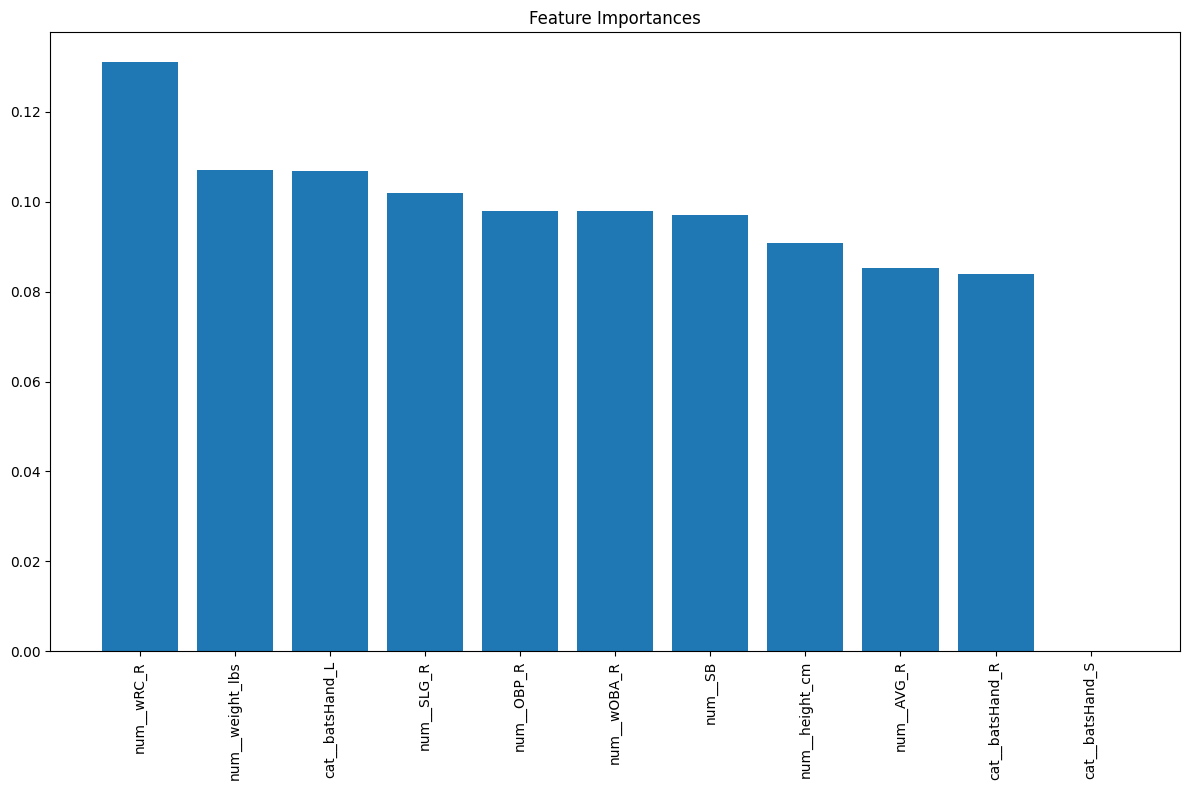

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature names from the preprocessor
feature_names = best_model_R.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from the model
feature_importances = best_model_R.named_steps['classifier'].feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")

# Use the sorted indices to order feature names
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
# Righty Model With New players best params
new_players_data = pd.read_csv('TamuPlayerStats.csv')
new_players_data = new_players_data.rename(columns={'height': 'height_cm', 'weight': 'weight_lbs'})
new_players_data['height_cm'] = new_players_data['height_cm'] * 2.54
new_players_data = new_players_data.round(decimals=4)
new_players_data = new_players_data.sort_values(by='AB_R', ascending=False)
new_players_data = new_players_data.head(16)

# Apply preprocessing to the data
new_players_preprocessed = best_model_R.named_steps['preprocessor'].transform(new_players_data[feature_columns_R])

# Predict probabilities
probabilities = best_model_R.named_steps['classifier'].predict_proba(new_players_preprocessed)

# Calculate suitability scores and select the top 9 players
suitability_scores = probabilities.sum(axis=1)
top_player_indices = np.argsort(-suitability_scores)[:9]
selected_players = new_players_data.iloc[top_player_indices]

# Predict probabilities for the top 9 selected players
selected_probabilities = probabilities[top_player_indices]

# Convert to cost matrix and apply Hungarian algorithm
cost_matrix = 1 - selected_probabilities
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Construct and display the DataFrame with assigned positions
assigned_df = pd.DataFrame({
    'PlayerName': selected_players['playerFullName'],
    'AssignedPosition': col_ind + 1
}).sort_values('AssignedPosition')

assigned_df.reset_index(drop=True, inplace=True)
print(assigned_df)

          PlayerName  AssignedPosition
0      Jackson Appel                 1
1      Hayden Schott                 2
2  Braden Montgomery                 3
3    Jace Laviolette                 4
4     Gavin Grahovac                 5
5        Ryan Targac                 6
6      Caden Sorrell                 7
7        Kaeden Kent                 8
8      Ali Camarillo                 9


In [ ]:
# Alternative way of using Hungarian Algo where we use all combinations
from itertools import combinations
new_players_data = pd.read_csv('TamuPlayerStats.csv')
new_players_data = new_players_data.rename(columns={'height': 'height_cm', 'weight': 'weight_lbs'})
new_players_data['height_cm'] = new_players_data['height_cm'] * 2.54
new_players_data = new_players_data.round(decimals=4)
new_players_data = new_players_data.sort_values(by='AB_R', ascending=False)
new_players_data = new_players_data.head(16)

# Preprocess the new player data
new_players_preprocessed = best_model.named_steps['preprocessor'].transform(new_players_data[feature_columns])

# Predict probabilities for each batting order position for all new players
probabilities = best_model.named_steps['classifier'].predict_proba(new_players_preprocessed)

# Define a function to calculate the total cost given a subset of players
def calculate_total_cost(players_indices):

    subset_probabilities = probabilities[players_indices, :]
    cost_matrix = 1 - subset_probabilities
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    return total_cost, row_ind, col_ind

# Get all combinations of players indices
player_indices = range(len(new_players_data))
player_combinations = combinations(player_indices, 9)

# Try each combination to find the one with the lowest total cost
min_total_cost = float('inf')
best_combination = None
best_assignment = None

for combo in player_combinations:
    total_cost, row_ind, col_ind = calculate_total_cost(combo)
    if total_cost < min_total_cost:
        min_total_cost = total_cost
        best_combination = combo
        best_assignment = col_ind + 1

# Construct the DataFrame with the best combination and assignments
assigned_df = pd.DataFrame({
    'PlayerName': new_players_data.iloc[list(best_combination)]['playerFullName'],
    'AssignedPosition': best_assignment
}).sort_values('AssignedPosition')

assigned_df.reset_index(drop=True, inplace=True)
print(assigned_df)


          PlayerName  AssignedPosition
0         Ted Burton                 1
1    Jace Laviolette                 2
2  Braden Montgomery                 3
3     Blake Binderup                 4
4     Gavin Grahovac                 5
5      Ali Camarillo                 6
6      Caden Sorrell                 7
7          Hank Bard                 8
8    Travis Chestnut                 9
